In [5]:
#Import du script de comparaison
from Comparison_scripts.monte_carlo_compare import run_comparison
# from Comparison_scripts.monte_carlo_compare import run_dl_model_comparison
from Signal_generator.generate_signal import *
import torch.nn.functional as F
from Algorithmes.music import estimate_angles
import numpy as np
import torch.nn as nn
from Plots.draw_plot import plot_single_music
import random
import torch

In [6]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():  
    torch.cuda.manual_seed_all(42)

In [3]:
from Models.compare import *
Q = 8
N = 2**12
#models_deep_music1 = load_deep_music("DeepMusic_subregion_1", model_class=DeepMusicModel, outputs=[121])
models_deep_music2 = load_deep_music("DeepMusic_subregion_1", model_class=DeepMusicModel, outputs=[512 for _ in range(8)])

In [8]:
# Fonction pour reconstruire le spectre à partir des Q réseaux de neurones
def reconstruct_music_spectrum(segments, Q, N):
    """
    Reconstruct the full music spectrum from its segmented parts.

    Args:
    segments (list of ndarrays): The segmented parts of the music spectrum.
    Q (int): The number of segments.
    N (int): The total number of points in the full music spectrum.

    Returns:
    ndarray: The reconstructed music spectrum.
    """
    # Initialize the reconstructed spectrum with zeros
    reconstructed_spectrum = np.zeros(N, dtype=float)
    
    # Length of each segment
    segment_length = N // Q

    
    # Iterate over each segment and place it in the reconstructed spectrum
    for q, segment in enumerate(segments):
        start_index = q * segment_length
        if q < Q - 1:
            # For all but the last segment, use the segment length
            end_index = start_index + segment_length
        else:
            # For the last segment, it can be longer if N is not divisible by Q
            end_index = N
        # Make sure segment is the correct shape
        segment = segment[:end_index - start_index]
        reconstructed_spectrum[start_index:end_index] = segment
    
    return reconstructed_spectrum

#Fonction pour prédire l'angle
def deep_music_pred_2(X, nbSensors, nbSources,Q, N):
    input_tensor = torch.tensor(generate_R_hat_with_phase(X), dtype=torch.float32).unsqueeze(0)
    for i in range(0,Q-1):
        models_deep_music2[0][i].eval()
    with torch.no_grad():
        a = []
        for q in range(0,Q):
            qi = models_deep_music2[0][q](input_tensor).numpy()[0]
            a.append(qi)
        # Estimer les angles à partir du spectre MUSIC
        b = reconstruct_music_spectrum(a, Q, N)
        estimated_angles = estimate_angles(nbSources, b, np.linspace(-60, 60, N))
    
    return estimated_angles

#Fonction pour donner le spectre prédit 
def deep_music_pred_c(X, nbSensors, nbSources,Q, N):
    input_tensor = torch.tensor(generate_R_hat_with_phase(X), dtype=torch.float32).unsqueeze(0)
    for i in range(0,Q-1):
        models_deep_music2[0][i].eval()
    with torch.no_grad():
        a = []
        for q in range(0,Q):
            qi = models_deep_music2[0][q](input_tensor).numpy()[0]
            a.append(qi)
        # Estimer les angles à partir du spectre MUSIC
        b = reconstruct_music_spectrum(a, Q, N)
        estimated_angles = estimate_angles(nbSources, b, np.linspace(-60, 60, N))
    
    return a

def deep_music_pred_single_c(X, nbSensors, nbSources,Q, N, p):
    input_tensor = torch.tensor(generate_R_hat_with_phase(X), dtype=torch.float32).unsqueeze(0)
    models_deep_music2[0][p].eval()
    with torch.no_grad():
        qp = models_deep_music2[0][p](input_tensor).detach().cpu().numpy()
        # Estimer les angles à partir du spectre MUSIC
        estimated_angles = estimate_angles(nbSources, qp, np.linspace(-60, 60, N//Q))
    return a

In [120]:
# Algorithmes à importer
from Algorithmes.beamforming import beamforming_method
from Algorithmes.music import music_method

In [121]:
# Appel des algorithmes à comparer. clé: nom de l'algorithme, valeur: fonction de l'algorithme
# La fonction doit prendre en entrée les paramètres suivants: X, nbSensors, nbSources
# La fonction doit donner en sortie une liste de la forme [angleEstime1, angleEstime2] rangée dans l'ordre croissant
algorithms_to_compare = {
    "Beamforming": beamforming_method,
    "DeepMusic_subregions_2": deep_music_pred_2
}



In [122]:
nb_iterations = 100 # Nombre d'itérations de Monte Carlo pour chaque algorithme
nbSources = 2
nbSensors = 9
theta = [-20, 20] # Les deux angles d'origine des sources
two_symmetrical_angles = True # Si True, on a deux angles symétriques par rapport à 0.
# Favoriser de angles symmétriques : cela aura un effet similaire à doubler nb_itération sans doubler le temps de calcul

In [76]:
# Valeurs neutres pour les 5 paramètres à slider:
# nbTimePoints = 100
# var_ratio = [1] -> les deux signaux ont la même variance
# correlation = [0] -> les deux signaux sont indépendants
# snr = 10 -> le bruit est 10 fois plus petit que le signal
# perturbation_parameter_sd = 0 -> les capteurs sont parfaitement alignés

In [77]:
# Exemples de ranges intéressantes pour les paramètres à slider:
# var_ratio = [[1], [10], [50]]
# correlation = [[0], [0.9], [0.95], [0.99]]
# snr = [-10, -5, 0, 5, 10, 20]
# perturbation_parameter_sd = [0, 0.01, 0.1]

In [78]:
# IMPORTANT : le paramètre défini en temps que parameter_to_compare doit être sous forme d'une liste de valeurs. Exemples dans la cellule au dessus.
# Pour var_ratio et correlation, faites attention à bien avoir une liste de liste de réels s'ils sont en parameter_to_compare, et une liste de réels sinon.
nbTimePoints = 100
var_ratio = [1]
correlation = [0]
snr = [-10, 0, 10, 20]
perturbation_parameter_sd = 0

In [ ]:
# Les parameter_to_compare valides sont: "snr", "nbTimePoints", "correlation", "var_ratio" et "perturbation_parameter_sd"
parameter_to_compare = "snr" # Paramètre à faire slider

In [ ]:
import torch.nn.functional as F

run_comparison(parameter_to_compare, algorithms_to_compare, nb_iterations, nbSources, nbSensors, theta, nbTimePoints, snr, correlation, var_ratio, perturbation_parameter_sd, two_symmetrical_angles)

In [12]:
from Signal_generator.generate_signal import generate_X_matrix
from Signal_generator.generate_signal import generate_R_hat_with_phase

nbSources = 2 # Nombre de sources
nbSensors = 9 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 10 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = -10 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = 10 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var_ratio = [1] # Liste qui donne le rapport entre la variance du signal 1 et celui des autres sources (ex: [2, 3] signifie que la source 2 a une variance 2 fois plus grande que la source 1, et la source 3 a une variance 3 fois plus grande que la source 1)
correlation_List = [0] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche
perturbation_parameter_sd = 0 # Écart-type de la distribution normale qui génère les erreurs de calibration des capteurs

thetaList = [theta1,theta2]
X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd)
print("DeepMusic_subregions_2 :", deep_music_pred_2(generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd), nbSensors, nbSources, Q, N))

DeepMusic_subregions_2 : [-44.76190476  43.2967033 ]


In [15]:
for i in range(1,30):
    thetaList = [-i,i]
    X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd)
    print("[{},{}]:".format(-i,i), deep_music_pred_2(generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd), nbSensors, nbSources, Q, N))

[-1,1]: [-48.16117216   1.3040293 ]
[-2,2]: [-48.16117216   1.3040293 ]
[-3,3]: [-48.16117216   1.3040293 ]
[-4,4]: [ 1.3040293 43.2967033]
[-5,5]: [-44.76190476  43.2967033 ]
[-6,6]: [-44.76190476  43.2967033 ]
[-7,7]: [-44.76190476  43.2967033 ]
[-8,8]: [-44.76190476  43.2967033 ]
[-9,9]: [-44.76190476  43.2967033 ]
[-10,10]: [-44.76190476  43.2967033 ]
[-11,11]: [-44.76190476  43.2967033 ]
[-12,12]: [-44.76190476  43.2967033 ]
[-13,13]: [-44.76190476  43.2967033 ]
[-14,14]: [-44.76190476  43.2967033 ]
[-15,15]: [-44.76190476  43.2967033 ]
[-16,16]: [-55.63369963 -44.76190476]
[-17,17]: [-55.63369963 -44.76190476]
[-18,18]: [-55.63369963 -44.76190476]
[-19,19]: [-55.63369963 -44.76190476]
[-20,20]: [-55.63369963 -44.76190476]
[-21,21]: [-55.63369963 -44.76190476]
[-22,22]: [-55.63369963 -44.76190476]
[-23,23]: [-51.003663   -44.76190476]
[-24,24]: [-51.003663   -44.76190476]
[-25,25]: [-51.003663   -44.76190476]
[-26,26]: [-51.003663   -44.76190476]
[-27,27]: [-55.63369963 -44.761904

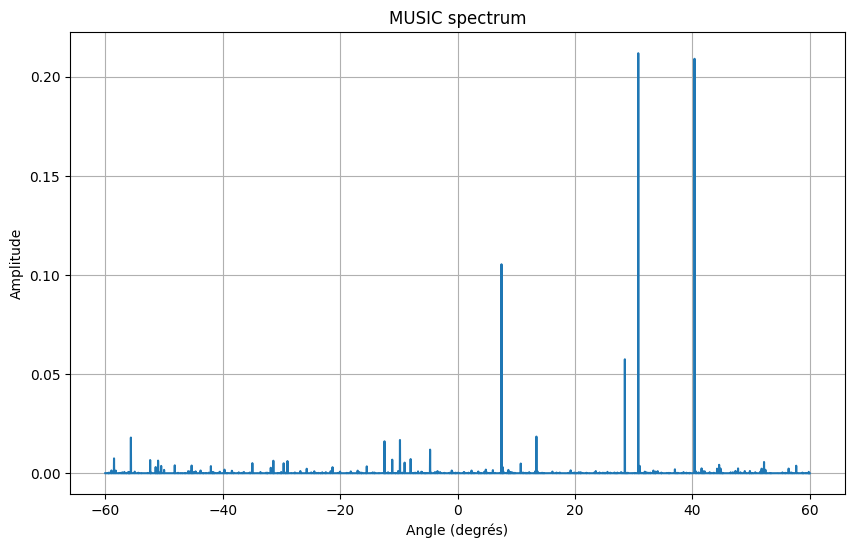

In [13]:
from Algorithmes.music import music_method
spectre_c = deep_music_pred_c(X=generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd),nbSensors=nbSensors,nbSources=nbSources,Q=Q,N=N)
plot_single_music(spectre_c[0], np.linspace(-60,60,N))